# How to use the network to rr translator

Packages used : `pandas`, `numpy`, `networkx`, `os`, `re`, `warnings`

This tutorial is meant to be used with `ecoserv`

## Structure

The code files are placed in the `libraries/` folder at the root of the server. The `init.py` file also placed at the root allows to load the libraries :

[Note that it has to be modified to set up the proper path]

In [1]:
%run ~/init.py

The code is written in python ; it is mostly based on two object classes: `rr_network` and `rr_list`.

`rr_list` is a class of objects designed to directly manipulate the set of reaction rules. It contains a list of nodes and their initial states, a list of rules, methods to directly add rules corresponding to ecological links or modify the rules, and methods to export the reaction rules into a `.rr` file that can be sent to ecco or ecoserv.

`rr_network` is an extension of the networkx `DiGraph` class, with additional methods to add ecologically meaningful links and to convert the network into the corresponding rules. It allows to manipulate ecological networks as such, to export them as an `rr_list`, or to directly write the corresponding `.rr` file.

## Useful functions
*(In the `utils.py`file)*

The `create_rule` function allows to automatically write rule strings based on the involved nodes:

In [2]:
create_rule("A", "+", "B", "-")

' A+ >> B-'

In [3]:
create_rule(["A","D"], "+", ["B","C"], "-", comment = "It accepts lists as inputs")

' A+, D+ >> B-, C-\t\t # It accepts lists as inputs'

In [4]:
create_rule(["A","D","X"], ["+","-","+"], ["B","C"], "-", comment = "", tag = "tagged rule")

'[tagged rule] A+, D-, X+ >> B-, C-'

For compact writing of simple rules, four simpler derived versions are implemented (apbp = "a plus b plus", apbm = "a plus b minus", ambp = "a minus b plus", ambm = "a minus b minus")

In [5]:
apbm("A","B")

' A+ >> B-'

In [6]:
ambm(["C","D"], "E")

' C-, D- >> E-'

In [7]:
apbp("B", ["E","G"])

' B+ >> E+, G+'

In [8]:
ambp("C", "X", tag = "1", comment = "tags and comments can be written as previously")

'[1] C- >> X+\t\t # tags and comments can be written as previously'

## The rr_list class
*(In the `rr_list.py`file)*

In [9]:
test_list = rr_list(nodes_list = ["A", "B", "D"]) # it can also be initialized without any parameter

Objects from this class have four attributes : `rules`, containing the rules, `constraints`, containing constraints, `nodes`, containing the nodes of the system, and `nodes_init`, containing the initial state of the nodes.
They can all four be manipulated as any python list.

In [10]:
print(test_list.nodes)
test_list.nodes.append("E")
print(test_list.nodes)

['A', 'B', 'D']
['A', 'B', 'D', 'E']


In [11]:
test_list.nodes_init = [1,0,1,1] # 0 corresponds to a species initially absent, 1 to a species initially present
print(test_list.nodes_init)

[1, 0, 1, 1]


The `rules` attribute is a list containing the character strings of the rules defined for the system.

A first, direct way to manipulate it is to directly add the rules:

In [12]:
test_list.rules.append(create_rule(["A","D","B"], ["+","-","+"], ["A","C"], "-"))
test_list.rules.append(apbm("B", "D"))

print(test_list.rules)

test_list.rules.remove(" B+ >> D-")

print(test_list.rules)

[' A+, D-, B+ >> A-, C-', ' B+ >> D-']
[' A+, D-, B+ >> A-, C-']


Be careful, as there is nothing specific to deal with rules present twice, species absent from the system.

It is safer to implement the rules through dedicated methods. The `add_competition`, `add_predation`, `add_appearance` rules methods allow to directly implement the corresponding rules.

### Competition

The consequence of competition at the scale of community is the possible exclusion of a competitor species. We therefore translate a competition link between species A and B as two rules :
+ A+ >> B-
+ B+ >> A-

If the competition is asymmetric, only one of these two rules may be present.

In [13]:
test_list.add_competition("D","E")
test_list.add_competition("G", "A", asymmetric = True)

print(test_list.rules)

[' A+, D-, B+ >> A-, C-', ' D+ >> E-', ' E+ >> D-', ' G+ >> A-']


/home/mathieu.de-goer/libraries/rr_list.py:129: UserWarning: node G not defined !
  warn("node {0} not defined !".format(A))


If a node that is not present in the system is used as argument, a warning message will be displayed (but the rules are still added)

### Predation
Predation is more subtle to define, as we need to know all preys of a given predator to know in which conditions it can survive.

We define two kind of preys :
+ "main" preys, that can sustain the population of the predator.
+ "secondary" preys, that can be eaten but that are unable to sustain the population of the prey alone.

For a predator P eating main preys N1 and N2, and secondary preys S1 and S2, the consequences are :
+ P can drive N1 and N2 to extinction.
+ P can starve if N1 and N2 are absent.

The corresponding rules are then:
+ P+ >> N1-
+ P+ >> N2-
+ N1-, N2- >> P-

This last rule is removed if P is also an autotroph, or simply if it can survive without preys.

There are, then, two possibilities concerning S1 and S2:
+ Either we consider that P can drive S1 and S2 to extinction
+ Or we consider the case of preferential predation, and that P can drive S1 and S2 to extinction only if P1 and P2 are absent.

In the first case, we add to the previous rules :
+ P+ >> S1-
+ P+ >> S2-, 

and in the second case :
+ P+, N1-, N2- >> S1-
+ P+, N1-, N2- >> S2-


In [14]:
test_list.nodes.extend(["P", "N1", "N2", "S1", "S2"])
test_list.add_predation(predator = "P", preys_list = ["N1", "N2"], secondary_preys = ["S1", "S2"])

test_list.add_predation("A", ["B"], secondary_preys = ["E"], preferential = False)

print(test_list.rules)

[' A+, D-, B+ >> A-, C-', ' D+ >> E-', ' E+ >> D-', ' G+ >> A-', ' P+ >> N1-', ' P+ >> N2-', ' N1-, N2- >> P-', ' P+, N1-, N2- >> S1-', ' P+, N1-, N2- >> S2-', ' A+ >> B-', ' B- >> A-', ' A+ >> E-']


### Appearance

As for now the conditions allowing or not a species to invade/appear, there is simply a way to add a rule allowing a species to appear, specifying which other nodes should be present or absent to allow it.

The `rr_network` object (see below) is probably more relevant to deal with appearances.

In [15]:
test_list.add_appearance("A", presence_conditions = ["B"], absence_conditions = ["E", "P"])
print(test_list.rules)

[' A+, D-, B+ >> A-, C-', ' D+ >> E-', ' E+ >> D-', ' G+ >> A-', ' P+ >> N1-', ' P+ >> N2-', ' N1-, N2- >> P-', ' P+, N1-, N2- >> S1-', ' P+, N1-, N2- >> S2-', ' A+ >> B-', ' B- >> A-', ' A+ >> E-', ' E-, P-, B+ >> A+']


### Including matrices
It is also possible to directly write the rules corresponding to the interaction matrix of the system, choosing the corresponding interaction. The matrix dimensions should correspond to the system's number of nodes.

In [16]:
test_list_2 = rr_list(["A","B","C"])

For predation, the matrix should be lower diagonal (S_ij > 0 if species i is eaten by species j). A "1" in the matrix will be interpreted as a "main" predation link ; a number between 0 and 1 as a "secondary" predation.
The matrix should be a numpy array.

In [17]:
pred_mat = np.array([[0,0,0], [1,0, 0], [0.5, 1, 0]])
test_list_2.include_matrix(pred_mat, interaction_choice="predation")
print(test_list_2.rules)

[' A+ >> B-', ' B- >> A-', ' A+, B- >> C-', ' B+ >> C-', ' C- >> B-']


For competition, the matrix should be a numpy array containing ones when a species can outcompete the other (S_ij = 1 if species i is excluded by species j).

In [18]:
comp_mat = np.array([[0,1,0], [0,0, 1], [1, 0, 0]])
test_list_2.include_matrix(comp_mat, interaction_choice="competition")
print(test_list_2.rules)

[' A+ >> B-', ' B- >> A-', ' A+, B- >> C-', ' B+ >> C-', ' C- >> B-', ' A+ >> C-', ' B+ >> A-', ' C+ >> B-']


### Exporting the .rr file

Once the rules are correctly defined, the .rr file can be exported using the `write_file` method:

In [19]:
#test_list.nodes.extend(["C","G"])
test_list_2.nodes_init = [1,0,1]
test_list_2.write_file(filename = "tuto")

the rr file 'tuto.rr' already exists. Are you sure that you want to override it? (y/n) 
y


Remarks :
+ If the nodes have not been initialized, they will all be set initially present
+ If the file already exists, confirmation will be asked before overriding the file. The option "sure = True" allows to automatically override files with the same name.
+ It is possible to choose where the file will be created using the `folder = "[name]"` option.

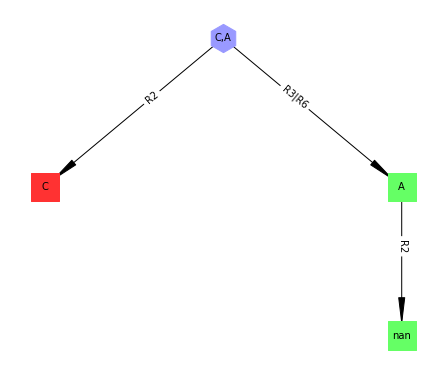

In [20]:
%run -m ecoserv tuto.rr
model.fg("draw", engine = "dot", scale = 0.5, labels = "on")

Finally, the `write_universe_file` method allows to automatically write the file allowing to compute the state universe corresponding to the set of rules (the suffix "_universe" will be added to the filename).

In [21]:
test_list_2.write_universe_file(filename = "tuto")

the rr file 'tuto_universe.rr' already exists. Are you sure that you want to override it? (y/n) 
y


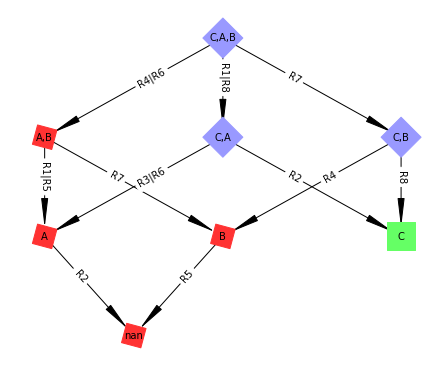

In [22]:
%run -m ecoserv tuto_universe.rr
def init (on, off, **rest):
    return "i" in off
model.fg["i"] = init
model.fg = model.fg["i", True]
model.fg("draw", engine = "dot", scale = 0.5, labels = "on")

## Framework - example using the Weatherby 1998 system
The code is intended to be used as a script, following this structure:
+ creation of the rr_list object with the list of nodes
+ addition of the rules using the standard methods
+ custom modification of the rules if necessary (if something has not been implemented).
+ exportation as a .rr file

The creation of the rr file for the Weatherby 1998 experiments is presented below as an example:

In [23]:
# initialization
weatherby_rr = rr_list(nodes_list = ["A", "B", "C", "E", "P", "T"])

# addition of the predation links
weatherby_rr.add_predation("A", preys_list = ["P"], secondary_preys = ["B", "E", "C", "T"], preferential =  True)
weatherby_rr.add_predation("B", preys_list = ["C", "T"], autotroph = True)
weatherby_rr.add_predation("E", preys_list = [], secondary_preys = ["C", "T"])

# addition of the competition links
weatherby_rr.add_competition("C", "T")
weatherby_rr.add_competition("P", "C", asymmetric = True)
weatherby_rr.add_competition("P", "T", asymmetric = True)

# addition of the C+ >> C- rule
weatherby_rr.rules.append(' C+ >> C-')
# NB : it could also be weatherby_rr.add_predation("C", preys_list = [])

# removal of useless rules (made irrelevant by the C+ >> C- and E+ >> E- rules)
weatherby_rr.rules.remove(' A+, P- >> E-')
weatherby_rr.rules.remove(' A+, P- >> C-')
weatherby_rr.rules.remove(apbm("B", "C"))
weatherby_rr.rules.remove(apbm("E", "C"))
weatherby_rr.rules.remove(apbm("P", "C"))
weatherby_rr.rules.remove(apbm("T", "C"))

# initialization and exportation of a .rr file
weatherby_rr.nodes_init = (1,0,0,1,0,1)
weatherby_rr.write_file("weatherby_AET")

# exportation of the universe file
weatherby_rr.write_universe_file("weatherby")

the rr file 'weatherby_AET.rr' already exists. Are you sure that you want to override it? (y/n) 
y
the rr file 'weatherby_universe.rr' already exists. Are you sure that you want to override it? (y/n) 
y


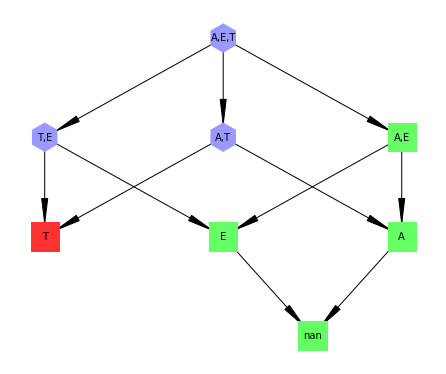

In [24]:
%run -m ecoserv weatherby_AET.rr
model.fg("draw", labels = "on", scale=0.5, edges_labels=False, engine = "dot")

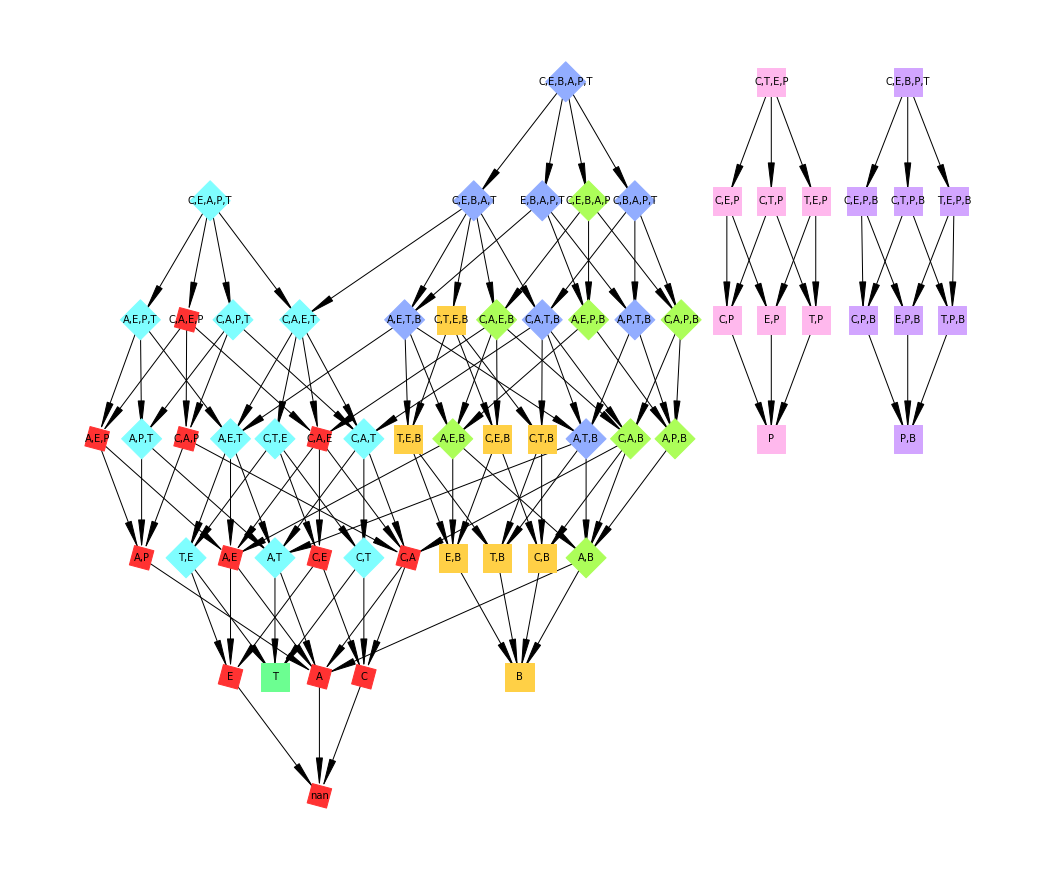

In [25]:
%run -m ecoserv weatherby_universe.rr
def init (on, off, **rest):
    return "i" in off
model.fg["i"] = init
model.fg = model.fg["i", True]
model.fg("draw", labels = "on", edges_labels = False, scale=1.2, engine = "dot")

## The rr_network class

This class of objects is intended to directly handle ecological networks and to provide an automated way to translate them into the corresponding set of reaction rules.
It is an overlayer based on the networkx package, providing a translation towards the rr_list class mentionned above.

An rr_network object is basically a nx.DiGraph object to which some methods were added. All methods from the DiGraph class can therefore be used:
https://networkx.org/documentation/stable/reference/classes/digraph.html?highlight=digraph#networkx.DiGraph

A tutorial providing the basics of networkx can be found here: https://networkx.org/documentation/stable/tutorial.html

The network is created initially empty. The standard networkx methods allow to add nodes or edges (which automatically creates the corresponding nodes). This should allow, in particular, to directly import data from real networks or generate random networks using standard methods (although I didn't do it a lot, and therefore there might be modifications to make in order for it to be really convenient).

In [26]:
test_net = rr_network()
test_net.add_node("A")
test_net.add_edge("C","P")
print(test_net.nodes)
print(test_net.edges)

['A', 'C', 'P']
[('C', 'P')]


Like for the rr_list, standard methods allow to directly create ecologically meaningful links, with a similar syntax (except that the options related to link interpretation come later in the workflow).

The type of link is stored in the `kind` attribute of each link. It should correspond to a kind of link that is already defined ("competition", "predation", "secondary_predation")

In [27]:
test_net.add_competition("A", "B")
test_net.add_predation("A", preys_list = ["B", "E"], secondary_preys = ["C"])

print(nx.get_edge_attributes(test_net,"kind"))

test_net.edges['C','P']["kind"] = "competition"

print(nx.get_edge_attributes(test_net, "kind"))

{('A', 'B'): 'predation', ('A', 'E'): 'predation', ('A', 'C'): 'secondary_predation', ('B', 'A'): 'competition'}
{('A', 'B'): 'predation', ('A', 'E'): 'predation', ('A', 'C'): 'secondary_predation', ('C', 'P'): 'competition', ('B', 'A'): 'competition'}


It is also possible to add specific characteristic to nodes using the `feature` attribute. For now this is used to specify that some nodes are autotroph-like (i.e. able to survive without preys).

[NB: this does not necessarily correspond to "true" autotrophs but rather to species that simply do not rely on their preys to survive]

In [28]:
test_net.nodes["C"]["feature"] = "autotroph"

### Exporting the reaction rules

The `rr_network` class has a `create_rr` method that allows to translate a network into the correponding `rr_list` object.

The edges that have a known `kind` attribute will be translated based on the methods of the `rr_list` class. Edges without this attribute will simply be ignored.

Both `allow_appearance` and `strong_dependance` options can be used (see the section above on the rr_list). Both are set to `True` by default. A set of options can be used to define what are the conditions allowing species to enter the system (see the documentation of the method in the rr_network.py file).

It is also preferable to set the initial values of the nodes at this stage (it is more convenient). It is stored in the `nodes_init` attribute of the network. The `initialize_nodes` method allows to set which nodes are initially present, the `set_node_init` to change a specific node value. Note that this is not mandatory as the rr_list class also allows to do so (but in a less convenient way).

In [29]:
test_net.initialize_nodes(initially_present = ["A", "P", "C"])
test_net.set_node_init("E", 1)

test_net.nodes_init

,nodes,init
0,A,1.0
1,C,1.0
2,P,1.0
3,B,0.0
4,E,1.0


In [30]:
test_list_3 = test_net.create_rr()
test_list_3.rules

[' A+ >> B-',
 ' A+ >> E-',
 ' B-, E- >> A-',
 ' A+, B-, E- >> C-',
 ' A+ >> B-',
 ' B+ >> A+',
 ' E+ >> A+',
 ' C+ >> A+',
 ' C- >> C+',
 ' P+ >> C-',
 ' P- >> P+',
 ' B- >> B+',
 ' E- >> E+']

Finally, the `write_rr_file` method allows to directly write the .rr file (a temporary rr_list object is created but not stored). The `universe` option allows to write the universe file.

In [31]:
test_net.write_rr_file(filename = "test_network_to_rr", universe = True, allow_appearance = False)

the rr file 'test_network_to_rr_universe.rr' already exists. Are you sure that you want to override it? (y/n) 
y


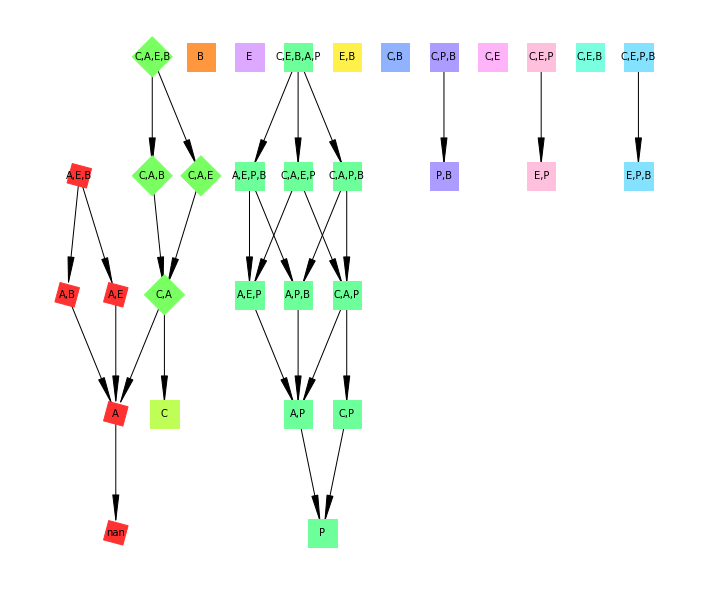

In [32]:
%run -m ecoserv test_network_to_rr_universe.rr
def init (on, off, **rest):
    return "i" in off
model.fg["i"] = init
model.fg = model.fg["i", True]
model.fg("draw", labels = "on", edges_labels = False, scale=0.8, engine = "dot")

### Miscellaneous

It is easy to draw the network using the `draw_circular` function of the networkx package.

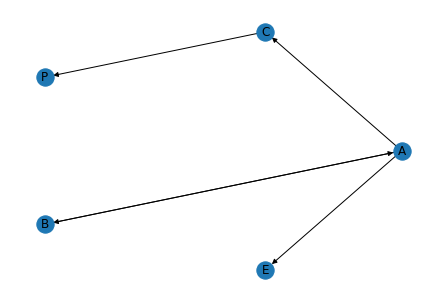

In [33]:
nx.draw_circular(test_net, with_labels = True)

There is also a command to derive a sub-network corresponding to the network considering only active nodes (i.e. in a given state), for example to analyze its structure.

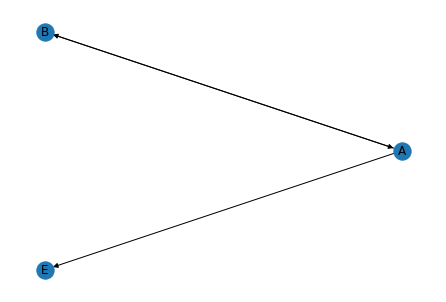

In [34]:
test_net_ABE = test_net.network_from_state(present = ["A","B","E"])
nx.draw_circular(test_net_ABE, with_labels = True)

An example of use of the rr_network class to generate a 6-species random network and compute its state universe can be seen below:

(Note that it can be useful to use the `write_edgelist` function of the networkx package to see the original network when it is generated randomly. However this doesn't save the attributes of the nodes (the "autotroph" feature is not kept in memory) - there is certainly a way to do so but I haven't taken the time.

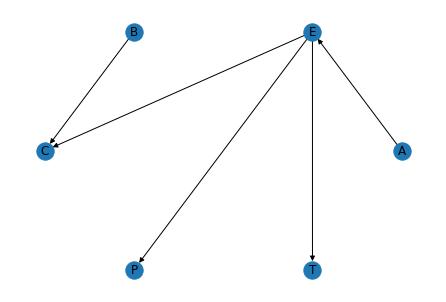

In [35]:
import random as rd
species = [["A"],["B", "E"],["C", "P", "T"]]

random_net = rr_network() # Create the object

# Predation of level 3 on levels 2 and 1
for source in species[0]:
    for target in species[1]+species[2] :
        interaction = rd.choice(["predation","secondary_predation", None])
        if not interaction == None:
            random_net.add_edge(source, target, kind = interaction)

# Predation of level 2 on level 1
for source in species[1]:
    for target in species[2] :
        interaction = rd.choice(["predation","secondary_predation", None])
        if not interaction == None:
            random_net.add_edge(source, target, kind = interaction)

# Some species of level 1 may be able to subsist without preys.
for sp in species[1]:
    if rd.random() < 0.4:
        random_net.nodes[sp]["feature"] = "autotroph"

nx.draw_circular(random_net, with_labels = True) # plot the network
random_net.initialize_nodes() #initialize the nodes 
nx.write_edgelist(random_net, "random_test.edgelist") # export the list of edges
random_net.write_rr_file(filename = "random_test", sure = "y", universe = True, allow_appearance = False)

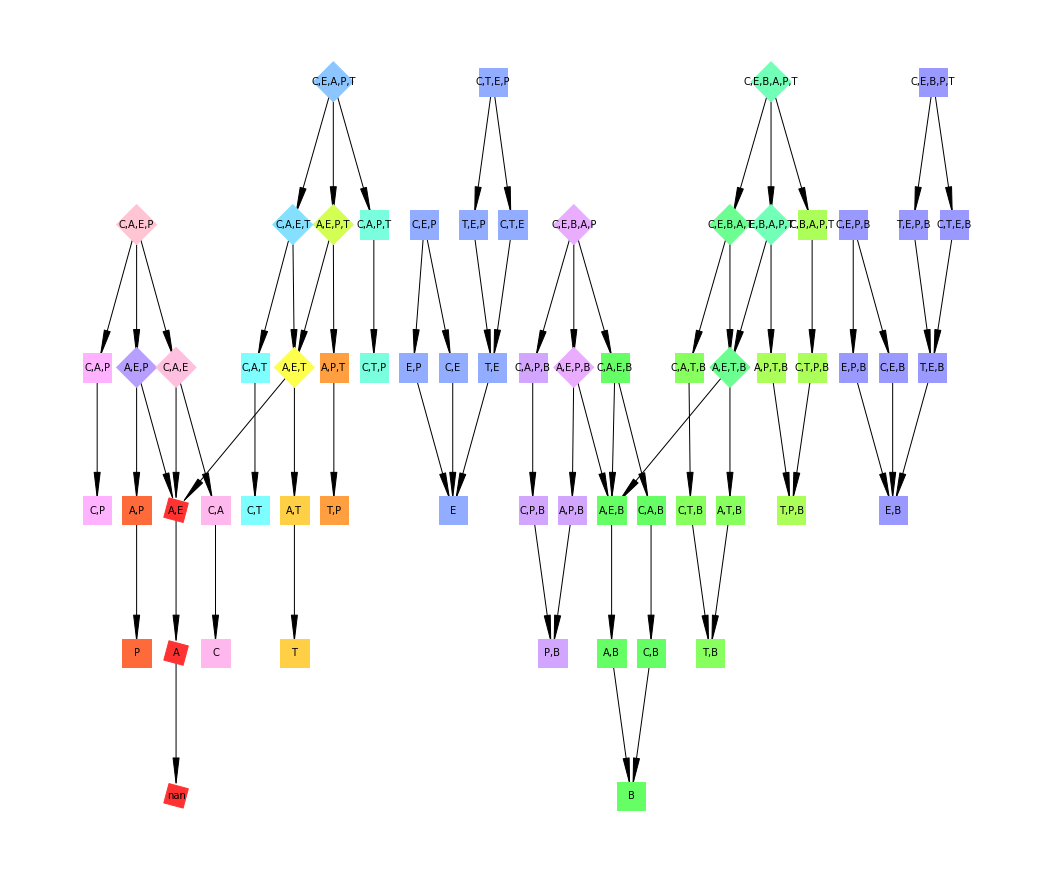

In [36]:
# Compute and plot the state universe
%run -m ecoserv random_test_universe.rr
def init (on, off, **rest):
    return "i" in off
model.fg["i"] = init
model.fg = model.fg["i", True]
model.fg("draw", labels = "on", edges_labels = False, scale=1.2, engine = "dot")

## Additional comments

This code is meant to be used and modified (for example to add new kinds of interactions or implement standard ways to deal with resources), and I just wanted to mention here how I think it should be updated - at least what I had in mind when writing it !
- The `rr_list` is meant to contain the real "translation" code, i.e. how a given link (or ensemble of links) is created. A new kind of interaction should be defined here by adding a method to add its corresponding rules to the `rr_list`.
- The `rr_network` is meant to make the link with the community of ecological networks. When a new type of interaction or node is added, a function to easily add this kind of link to the network should be added as a method for the `rr_network` class, and the `create_rr` function should be updated to take into account these links using the new method defined for the `rr_list` class.